# CNNs Deep Learning Post

---
I have been looking for a fun computer vision use-case that would enable me play around with a CNN implementation as I haven't worked on too many deep learning problems.  I like many others don't regularly organize and backup my wife and my iphone pictures.  As I was going through the thousands of pictures, I realized a common theme: 

<img src="./support_notebooks_markdown/Cnns_Post_Supporting_Files/Lass.jpg" width="150">

The above is my beloved puppy and she has been the object of much of our photography (we're a bit obsessed), unfortunately every one of my images is labelled is some non-descriptive format i.e. 000224444.jpg.  

This could be a fun use-case for a convolutional neural network (CNNs) as they are pretty good for computer vision, right?
> I would want to build a model that could accurately find my dog and/or identify a person and then run it through all the photos on my harddrive identifying which ones contained my pup.  I can then move those over to a relevant folder and then inspect the remainder, right?


First thing I'd need is access to a large number of images that I can train on.  Luckily I found 2 of these datasets on Udacity:
- [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip) 
- [people dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip)

I'd chosen to use pyTorch as I've heard good things related to it's Python first approach: [pytorch](https://pytorch.org/docs/stable/index.html)

In [9]:
ls -ltr ./dogImages

total 0
drwxr-xr-x@ 135 Shalu  staff  4320 Jun  7 13:18 train/
drwxr-xr-x@ 135 Shalu  staff  4320 Jun  7 13:18 valid/
drwxr-xr-x@ 136 Shalu  staff  4352 Jun  7 13:18 test/


Now I have directories above split out into 'train','valid', and 'test'.  Looking at the documentation around 
[data loaders](http://pytorch.org/docs/stable/torchvision/datasets.html) seems like ImageFolder is good for custom data sets. 

In [16]:
import os
import torchvision.transforms as transforms
from torchvision import datasets
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

#training on GPUs makes things a lot faster due to parrallel processing (I personally did this on Amazon AWs)
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [77]:
ls -ltr /data/

total 216
drwxr-xr-x    5 root root   4096 May 14  2018 dog_images/
drwxr-xr-x 5751 root root 208896 May 14  2018 lfw/
drwxr-xr-x    2 root root   4096 May 14  2018 bottleneck_features/


### Data Loading
Now I know how to load my data, but also I need to ensure that all pictures have the same sizes,etc.  Therefore a few [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform) are needed in addition to converting these numpy arrays into tensors. I just chose to use a size of 224 as that seemed to be commonly chosen.

In [78]:
num_workers = 0
# samples per batch to load
batch_size = 20
# percentage  to use as validation
valid_size = 0.2

data_dir = '/data/dog_images'

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), 
                                                            (0.5, 0.5, 0.5))])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), 
                                                            (0.5, 0.5, 0.5))])


train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)


# prepare data loaders 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=False)

loaders = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

In [14]:
ls -l -t dogImages/train | head -10

total 0
drwxr-xr-x@ 66 Shalu  staff  2112 Mar 27  2017 001.Affenpinscher/
drwxr-xr-x@ 60 Shalu  staff  1920 Mar 27  2017 002.Afghan_hound/
drwxr-xr-x@ 54 Shalu  staff  1728 Mar 27  2017 003.Airedale_terrier/
drwxr-xr-x@ 65 Shalu  staff  2080 Mar 27  2017 004.Akita/
drwxr-xr-x@ 79 Shalu  staff  2528 Mar 27  2017 005.Alaskan_malamute/
drwxr-xr-x@ 66 Shalu  staff  2112 Mar 27  2017 006.American_eskimo_dog/
drwxr-xr-x@ 52 Shalu  staff  1664 Mar 27  2017 007.American_foxhound/
drwxr-xr-x@ 68 Shalu  staff  2176 Mar 27  2017 008.American_staffordshire_terrier/
drwxr-xr-x@ 36 Shalu  staff  1152 Mar 27  2017 009.American_water_spaniel/


After looking at my dog data, I'll need to find out how many distinct breeds I have in order to train my model to identify the correct breed.

In [26]:
unique_dogs = (len(np.unique(train_data.classes)))
print (unique_dogs)

133


If I randomly chose a breed, I would have a probability of it being correct of 1/133, hopefully I can achieve an accuracy higher than that.

After googling around, I looked at a few CNN architectures and it seemed that 3-5 Convolutional layers would be a good start.  I then initially had 1 fully connected layer, but to be honest the model performed poorly so I added to additional layers and adjusted my learning rate down. 

### Architecture

In [97]:
kernel = 3
pad = 1
fc_output = 5000

In [98]:
import torch.nn as nn
import torch.nn.functional as F
    

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)       
        self.fc1 = nn.Linear(256 * 14 * 14, fc_output)
        self.fc2 = nn.Linear(fc_output, 2000)
        self.fc3 = nn.Linear(2000, unique_dogs)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        
        # flatten things out
        x = x.view(-1, 256 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = Net()

print(model)

# move tensors to GPU if available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=5000, bias=True)
  (fc2): Linear(in_features=5000, out_features=2000, bias=True)
  (fc3): Linear(in_features=2000, out_features=133, bias=True)
)


I now need to specify a loss function and an optimizer for my neural network. I chose cross entropy loss as according to the [documentation](http://pytorch.org/docs/stable/nn.html#loss-functions)

>It is useful when training a classification problem with C classes. If provided, the optional argument weight should be a 1D Tensor assigning weight to each of the classes. This is particularly useful when you have an unbalanced training set.

Now I have to choose an [optimizers](http://pytorch.org/docs/stable/optim.html) in order to update the weights of my computed gradients.  Stochastic Gradient Descent (SGD) and Adam are two popular methods, I settled on Adam after a little reading although I was cautioned that at times it has a tendency to overfit for these types of classification problems.

In [99]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_scratch.parameters(), lr=0.0001)

In [100]:
train_on_gpu

True

### Time to train the model on test and my validation set, saving the best performing one.

In [101]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    import time
    
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        start = time.time()
        train_loss = 0.0
        valid_loss = 0.0
        
        # train the model #
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            
            output = model_scratch(data)
            
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
                
        # validate  #
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            valid_loss_min = valid_loss            
    # return trained model
        print(f"Total Time: {(time.time() - start)/60:.3f} minutes")
    
    return model

n_epochs = 10

In [102]:
model = train(n_epochs, loaders, model, optimizer, 
                      criterion, use_cuda, 'model_fc3.pt')

Epoch: 1 	Training Loss: 4.809653 	Validation Loss: 4.693537
Validation loss decreased (inf --> 4.693537).  Saving model ...
Total Time: 3.238 minutes
Epoch: 2 	Training Loss: 4.553798 	Validation Loss: 4.436768
Validation loss decreased (4.693537 --> 4.436768).  Saving model ...
Total Time: 3.248 minutes
Epoch: 3 	Training Loss: 4.414593 	Validation Loss: 4.335376
Validation loss decreased (4.436768 --> 4.335376).  Saving model ...
Total Time: 3.248 minutes
Epoch: 4 	Training Loss: 4.302392 	Validation Loss: 4.215953
Validation loss decreased (4.335376 --> 4.215953).  Saving model ...
Total Time: 3.269 minutes
Epoch: 5 	Training Loss: 4.214605 	Validation Loss: 4.099763
Validation loss decreased (4.215953 --> 4.099763).  Saving model ...
Total Time: 3.255 minutes
Epoch: 6 	Training Loss: 4.107606 	Validation Loss: 4.036846
Validation loss decreased (4.099763 --> 4.036846).  Saving model ...
Total Time: 3.256 minutes
Epoch: 7 	Training Loss: 4.033701 	Validation Loss: 3.941356
Validati

In [103]:
# the most accurate model that got the best validation accuracy
model.load_state_dict(torch.load('modelfc3.pt'))

### Test It ###

In [104]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

test(loaders, model, criterion, use_cuda)

Test Loss: 3.713136


Test Accuracy: 13% (116/836)


### Not so good
I rapidly gained a lot of empathy as after all that, my model accuracy was a poor 13%. I realized just how complex creating a CNN from scratch can be. In comes in Transfer Learning, which is currently pretty popular in Deep Learning as it enables you to train deep learning networks on similar problems with sparse amounts of data.  Essentially I can apply a pre-trained model to a new problem.


### Transfer Learning

Transfer Learning is the reuse of a pre-trained model on a new problem. It is currently very popular in the field of Deep Learning because it enables you to train Deep Neural Networks with comparatively little data. 

Luckily, TorchVision has some models that have been [pretrained (https://pytorch.org/docs/master/torchvision/models.html) ....phewwwww

I'll choose the [VGG-16 model](https://arxiv.org/abs/1409.1556) from Cornell University.  It's been trained on the [ImageNet](http://www.image-net.org/) and here are all the categories of output [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  You can see that keys 151-268 are of dog breeds.

In [54]:
#let us use the same preprocessing and data loading as before, with notable difference
#I'm using a different transform to normalize the images as per the requirement of the VGG16 model

num_workers = 0
batch_size = 20
valid_size = 0.2
data_dir = '/data/dog_images'

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), 
                                                            (0.229, 0.224, 0.225))])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), 
                                                            (0.229, 0.224, 0.225))])

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle=False)

loaders = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

### Here is my model architecture

In [50]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model = models.vgg16(pretrained=True)
    
print (model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [51]:
# pretrained weights on feature parameters
for param in model_transfer.features.parameters():
    param.requires_grad = False

In [53]:
n_inputs = model_transfer.classifier[6].in_features

In [54]:
unique_dogs = (len(np.unique(train_data.classes)))
print (unique_dogs)

133


### Adjust the last fully-connected layer
The previous output had 1000 classes of which 151-268 are of dog breeds.  But I have only 133 classes of dog breeds and would like the output to 

In [55]:
last_layer = nn.Linear(n_inputs, unique_dogs)

In [56]:
print(last_layer)

Linear(in_features=4096, out_features=133, bias=True)


In [57]:
model_transfer.classifier[6] = last_layer

In [58]:
model_transfer

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [59]:
if use_cuda:
    model_transfer = model_transfer.cuda()

In [60]:
import torch.optim as optim

# again same reasoning as before as the classification problem is the same.
criterion_transfer = nn.CrossEntropyLoss()

# I only want to adjust the weights of the classifier and I'm using SGD here instead of Adam
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

In [66]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    import time
    
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        start = time.time()
        train_loss = 0.0
        valid_loss = 0.0
        # Train #
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            optimizer.zero_grad()
            
            output = model(data)
            
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
             
        # validation #
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            valid_loss_min = valid_loss            
        print(f"Total Time: {(time.time() - start)/60:.3f} minutes")
    
    return model

n_epochs = 10

In [67]:
# train the model
model = train(n_epochs, loaders, model, optimizer, criterion, use_cuda, 'model_vgg.pt')


Epoch: 1 	Training Loss: 3.181618 	Validation Loss: 2.487838
Validation loss decreased (inf --> 2.487838).  Saving model ...
Total Time: 2.524 minutes
Epoch: 2 	Training Loss: 2.241434 	Validation Loss: 1.812700
Validation loss decreased (2.487838 --> 1.812700).  Saving model ...
Total Time: 2.543 minutes
Epoch: 3 	Training Loss: 1.763387 	Validation Loss: 1.449733
Validation loss decreased (1.812700 --> 1.449733).  Saving model ...
Total Time: 2.515 minutes
Epoch: 4 	Training Loss: 1.548704 	Validation Loss: 1.284194
Validation loss decreased (1.449733 --> 1.284194).  Saving model ...
Total Time: 2.528 minutes
Epoch: 5 	Training Loss: 1.393220 	Validation Loss: 1.159660
Validation loss decreased (1.284194 --> 1.159660).  Saving model ...
Total Time: 2.541 minutes
Epoch: 6 	Training Loss: 1.291400 	Validation Loss: 1.172395
Total Time: 2.502 minutes
Epoch: 7 	Training Loss: 1.248277 	Validation Loss: 1.088839
Validation loss decreased (1.159660 --> 1.088839).  Saving model ...
Total Ti

In [69]:
# load the model with the best accuracy on validation
model.load_state_dict(torch.load('model_vgg.pt'))

In [70]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)
        loss = criterion(output, target)
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [71]:
test(loaders, model, criterion, use_cuda)

Test Loss: 0.488900


Test Accuracy: 84% (706/836)


### Pretty Neat
The accuracy has bumped up to 84%, not too shabby, probably can be improved with some more training data and tweaking a few more parameters.  So we now have 133 classes, let's try it out by writing a small algorithm and testing it out.

In [55]:
from PIL import Image

class_names = [item[4:].replace("_", " ") for item in train_data.classes]

def predict_my_breed(img_path):
    # load the image and return the predicted breed
    image = Image.open(img_path).convert('RGB')
    
    in_transform = transforms.Compose([
                        transforms.RandomResizedCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    if train_on_gpu:
        image = image.cuda()
    
    prediction = model_transfer(image)
    prediction = prediction.data.cpu().numpy().argmax()
    
    return class_names[prediction]

In [100]:
file = '/data/dog_images/train/103.Mastiff/Mastiff_06826.jpg'

In [104]:
print ('Dog Breed:', predict_my_breed(file))

Dog Breed: Mastiff


## Well that seems pretty accurate, let's try it out on my pooch
<br>
<img src="./support_notebooks_markdown/Cnns_Post_Supporting_Files/Lass.jpg" width="400">

In [216]:
lass = './support_notebooks_markdown/Cnns_Post_Supporting_Files/Lass.jpg'

In [182]:
predict_my_breed(lass)

'Bichon frise'

## Not too bad actually, she's a poodle mix, but I don't see that as prevalent in the training data set, so one way to improve this is to put more labradoodle mixes in there.

So now we have a dog breed classifier at 84%, let's grab a face detector, Udacity has a pretty cool example of using some predetermined face detection. OpenCV's has an implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  If you download one of the detectors in your directory you can play around as well, I downloaded the haarcascades.  

In [206]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline    

In [207]:
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

In [208]:
people_file = './post_images/mixed_images/Cameron_Diaz_0003.jpg'

Number of faces detected: 1


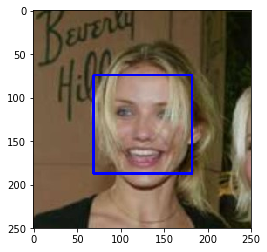

In [209]:
img = cv2.imread(people_file)
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# find faces in image
faces = face_cascade.detectMultiScale(gray)
# print number of faces detected in the image
print('Number of faces detected:', len(faces))
# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [210]:
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In the case of Cameron Diaz, it seems to work, so every time we can detect a face we should get a true.

In [211]:
face_detector(people_file)

True

But does it work for dogs?  

In [212]:
dog_file = './post_images/mixed_images/Affenpinscher_00003.jpg'

In [213]:
face_detector(dog_file)

False

Now I can write an algorithm, if it detects faces, then I can flag it, else I’ll try to figure out what breed of dog it is. Something like the below is what I’ll likely end up using.

In [222]:
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if face_detector(img_path)==False:
        print ('Dog Detected:', predict_breed_transfer(img_path))
    elif face_detector(img_path)==True:
        print ('Human Detected')
    else:
        print ('Not your dog nor a person')
